In [1]:
# Import libraries
import scanpy as sc
import anndata as ad 
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import celltypist
from celltypist import models

In [2]:
# Define paths to data files
meta_path = Path("../data/metadata.csv")
count_path1 = Path("../data/raw_data_supp2")
count_path2 = Path("../data/raw_data_supp6")
filtered_counts_path = Path("../data/filtered_counts")

In [3]:
# Import meta data as dataframe
meta_data = pd.read_csv(meta_path, index_col=0)
# Check
meta_data.info()
meta_data.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
Index: 45101 entries, TYPE to Polyp13CEPISSS_2453
Data columns (total 35 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   species__ontology_label                                   45101 non-null  object
 1   polyp                                                     36789 non-null  object
 2   disease__ontology_label                                   45101 non-null  object
 3   biosample_id                                              45101 non-null  object
 4   sex                                                       45101 non-null  object
 5   organism_age                                              45101 non-null  object
 6   organ__ontology_label                                     45101 non-null  object
 7   cell_type__ontology_label                                 36741 non-null  object
 8   specialcells  

/tmp/ipykernel_42743/1653597427.py:2: DtypeWarning: Columns (6,10,11,16,17,33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_data = pd.read_csv(meta_path, index_col=0)


,count,unique,top,freq
species__ontology_label,45101,2,Homo sapiens,45100
polyp,36789,4,YES,21690
disease__ontology_label,45101,3,chronic rhinitis,29137
biosample_id,45101,24,Polyp19BEPI,5625
sex,45101,3,male,23403
organism_age,45101,17,29,9279
organ__ontology_label,45101,3,ethmoid sinus,26839
cell_type__ontology_label,36741,15,secretory cell,12798
specialcells,26686,3,NO,26587
nCount_RNA,8361.0,4085.0,1144.0,12.0


In [4]:
# Load column names of experimental data
cell_id_1 = pd.read_csv(count_path1, delimiter="\t", index_col=0, nrows=1).columns.to_list()
cell_id_2 = pd.read_csv(count_path2, delimiter="\t", index_col=0, nrows=1).columns.to_list()
cell_id_combined = cell_id_1 + cell_id_2
# Filter meta data based on experimental cell ids
meta_data = meta_data[meta_data["CellID"].isin(cell_id_combined)]
# Sample 3,000 rows from meta data that will be used to restrict the count data
meta_data = meta_data.sample(n=3000, random_state=42)
# Select important columns of meta data
meta_data = meta_data[["CellID", "donor_id", "sex", "organism_age", "cell_type"]]
# Rename columns
meta_data.rename(columns={"CellID": "cell_id", "organism_age": "age"}, inplace=True)
# Remove index name
meta_data.index.name = None
# Sort by index
meta_data.sort_index(inplace=True)
# Check
meta_data

,cell_id,donor_id,sex,age,cell_type
Polyp11TOT_1002,Polyp11TOT_1002,320,female,55,CL_0002169
Polyp11TOT_1011,Polyp11TOT_1011,320,female,55,CL_0002169
Polyp11TOT_1036,Polyp11TOT_1036,320,female,55,CL_0000160
Polyp11TOT_1055,Polyp11TOT_1055,320,female,55,CL_0002169
Polyp11TOT_1063,Polyp11TOT_1063,320,female,55,CL_0000763
...,...,...,...,...,...
Polyp9TOT_968,Polyp9TOT_968,318,female,31,CL_0000084
Polyp9TOT_975,Polyp9TOT_975,318,female,31,CL_0000057
Polyp9TOT_976,Polyp9TOT_976,318,female,31,CL_0000786
Polyp9TOT_98,Polyp9TOT_98,318,female,31,CL_0000084


In [5]:
# Define functions to read and preprocess data
def read_chunks(file_path:str, meta_data) -> pd.DataFrame:
    """
    Reads a large tab-separated values (TSV) file in chunks, filtering the data based on metadata, and 
    returns a concatenated DataFrame with only the desired columns.

    Parameters:
    - file_path (str): The path to the TSV file to be read.
    - meta_data (pd.DataFrame): A DataFrame containing metadata. It should have a 'cell_id' column that specifies 
      which columns to keep from the input data.

    Returns:
    - pd.DataFrame: A DataFrame with concatenated and filtered data based on the metadata.
    """

    # Import count data as chunks and use only the rows that were defined by the meta data supsampling
    filtered_counts = pd.DataFrame()
    print(f"Processing {file_path}")
    count_data = pd.read_csv(
        file_path, 
        delimiter="\t",
        index_col=0,
        chunksize=100
        )

    # Define cell_ids to keep
    cell_ids_keep = meta_data["cell_id"].to_list()

    # Read count data, keep only rows that are in meta data
    for chunk_counter, chunk in enumerate(count_data):
        # Define intersection of cell ids between meta data and current chunk
        common_columns = np.intersect1d(chunk.columns, cell_ids_keep)
        # Filter out any columns that are not in meta data 
        chunk = chunk[common_columns]
        # Concat filtered columns to dataframe
        filtered_counts = pd.concat([filtered_counts, chunk], axis=0)
        # Print message after 10 chunks
        if chunk_counter % 10 == 0:
            print(f"Finished chunk {chunk_counter}")

    return filtered_counts

def match_indices(frame1, frame2) -> pd.DataFrame:
    """
    Matches the indices between two DataFrames, keeping only the rows with common indices,
    and returns a concatenated DataFrame with aligned and sorted rows.

    Parameters:
    - frame1 (pd.DataFrame): The first DataFrame to be aligned by indices.
    - frame2 (pd.DataFrame): The second DataFrame to be aligned by indices.

    Returns:
    - pd.DataFrame: A concatenated DataFrame with only the rows that share common indices
      from both input DataFrames. The DataFrame is sorted by index.
    """
    
    # Determine common indices
    common_indices = frame1.index.intersection(frame2.index)
    # Keep only rows with common indices and sort by indices
    frame1 = frame1.loc[common_indices].sort_index()
    frame2 = frame2.loc[common_indices].sort_index()
    # Concatenate dataframes
    return pd.concat([frame1, frame2], axis=1)

In [6]:
# Read and filter data
frame1 = read_chunks(file_path=count_path1, meta_data=meta_data)
frame2 = read_chunks(file_path=count_path2, meta_data=meta_data)
filtered_counts = match_indices(frame1=frame1, frame2=frame2)
# Save filtered data
filtered_counts.to_csv(filtered_counts_path)

# Savepoint: Load data
#filtered_counts = pd.read_csv(filtered_counts_path, index_col=0)

In [7]:
# Transpose counts
count_data = filtered_counts.transpose()
# Cast to float
count_data = count_data.astype(float)
# Sort by index
count_data.sort_index(inplace=True)
# Check
count_data.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,...,hsa-mir-125a,hsa-mir-3149,hsa-mir-3195,hsa-mir-335,hsa-mir-4259,hsa-mir-490,hsa-mir-6080,hsa-mir-7515,hsa-mir-8072,snoU2-30
Polyp11TOT_1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Polyp11TOT_1011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Polyp11TOT_1036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Polyp11TOT_1055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Polyp11TOT_1063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Construct variable dataframe
vars = pd.DataFrame(count_data.columns, index=count_data.columns)
vars.index.name = None
vars.head()

,0
A1BG,A1BG
A1BG-AS1,A1BG-AS1
A1CF,A1CF
A2M,A2M
A2M-AS1,A2M-AS1


In [9]:
# Construct anndata object
adata = ad.AnnData(
    X=count_data,
    obs=meta_data,
    var=vars
)

# Inspect object
print(adata)
print()
print(adata.var)
print()
# Access gene names
print(adata.var_names)

AnnData object with n_obs × n_vars = 3000 × 28246
    obs: 'cell_id', 'donor_id', 'sex', 'age', 'cell_type'
    var: 0

                         0
A1BG                  A1BG
A1BG-AS1          A1BG-AS1
A1CF                  A1CF
A2M                    A2M
A2M-AS1            A2M-AS1
...                    ...
hsa-mir-490    hsa-mir-490
hsa-mir-6080  hsa-mir-6080
hsa-mir-7515  hsa-mir-7515
hsa-mir-8072  hsa-mir-8072
snoU2-30          snoU2-30

[28246 rows x 1 columns]

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1',
       'A2ML1-AS2', 'A3GALT2', 'A4GALT',
       ...
       'hsa-mir-125a', 'hsa-mir-3149', 'hsa-mir-3195', 'hsa-mir-335',
       'hsa-mir-4259', 'hsa-mir-490', 'hsa-mir-6080', 'hsa-mir-7515',
       'hsa-mir-8072', 'snoU2-30'],
      dtype='object', length=28246)


# Quality control

In [10]:
# Create new variables (binary) based on if the gene is mitochondrial ribosomal or a hemoglobin gene
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[1(P)]")

# Check new columns
adata.var

,0,mt,ribo,hb
A1BG,A1BG,False,False,False
A1BG-AS1,A1BG-AS1,False,False,False
A1CF,A1CF,False,False,False
A2M,A2M,False,False,False
A2M-AS1,A2M-AS1,False,False,False
...,...,...,...,...
hsa-mir-490,hsa-mir-490,False,False,False
hsa-mir-6080,hsa-mir-6080,False,False,False
hsa-mir-7515,hsa-mir-7515,False,False,False
hsa-mir-8072,hsa-mir-8072,False,False,False


In [11]:
# Calculate QC metrices
sc.preprocessing.calculate_qc_metrics(
    adata,
    qc_vars=["mt", "ribo", "hb"],
    inplace=True, # Write metrices into anndata object
    log1p=True,
    percent_top=[20]
)

# Inspect adata object
print(adata.var.columns)
print(adata.obs.columns)

Index([                      0,                    'mt',
                        'ribo',                    'hb',
           'n_cells_by_counts',           'mean_counts',
           'log1p_mean_counts', 'pct_dropout_by_counts',
                'total_counts',    'log1p_total_counts'],
      dtype='object')
Index(['cell_id', 'donor_id', 'sex', 'age', 'cell_type', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_20_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb'],
      dtype='object')


... storing 'sex' as categorical
... storing 'cell_type' as categorical


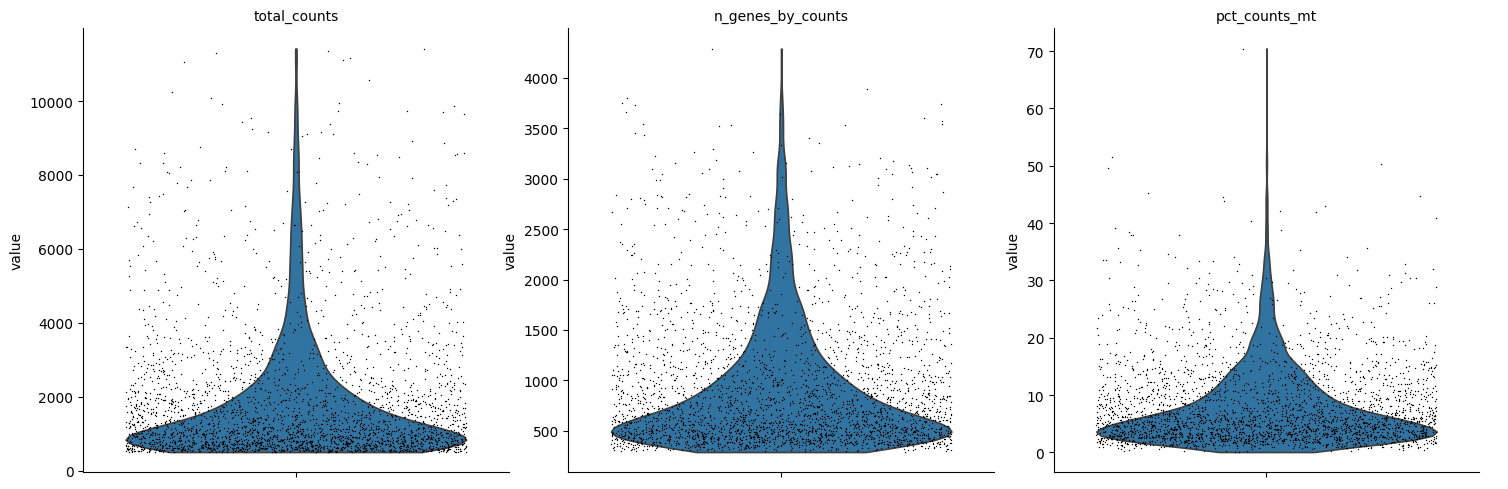

In [12]:
# Plot violin plots of some metrices
sc.plotting.violin(
    adata,
    keys=["total_counts", "n_genes_by_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    save="qc_plot.png"
)

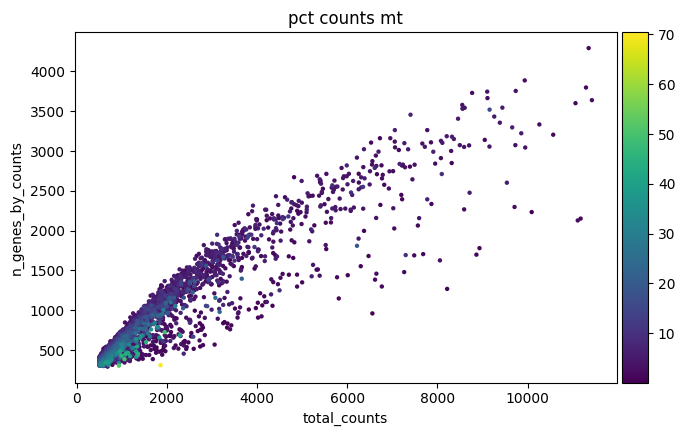

In [13]:
# Plot scatterplot coloured by percentage of mtDNA
sc.plotting.scatter(
    adata,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
)

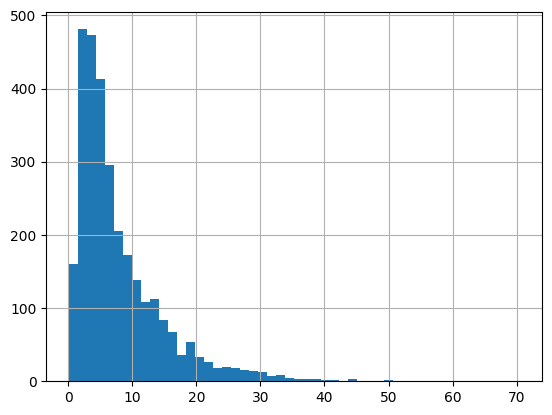

In [14]:
# Check histogram for mitochondrial gene fraction
adata.obs["pct_counts_mt"].hist(bins=50)
# Mark cells with more than 40% mitochondrial genes
adata.obs["mt_outlier"] = adata.obs["pct_counts_mt"] > 40
adata.obs["mt_outlier"].value_counts()
# Filter out cells
adata = adata[~adata.obs["mt_outlier"]].copy()

In [15]:
# First save unnormalized counts
adata.layers["raw_counts"] = adata.X.copy()

# Filer cells with less than 100 genes
sc.preprocessing.filter_cells(adata, min_genes=100)
# Filter genes that occur in less than 3 cells
sc.preprocessing.filter_genes(adata, min_cells=3)

# Check impact
adata

AnnData object with n_obs × n_vars = 2987 × 18478
    obs: 'cell_id', 'donor_id', 'sex', 'age', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'mt_outlier', 'n_genes'
    var: 0, 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'raw_counts'

# Doublet detection

In [16]:
# Run scrublet
sc.preprocessing.scrublet(adata)

# Check
adata.obs["predicted_doublet"].value_counts()

predicted_doublet
False    2984
True        3
Name: count, dtype: int64

# Normalization

<Axes: ylabel='Count'>

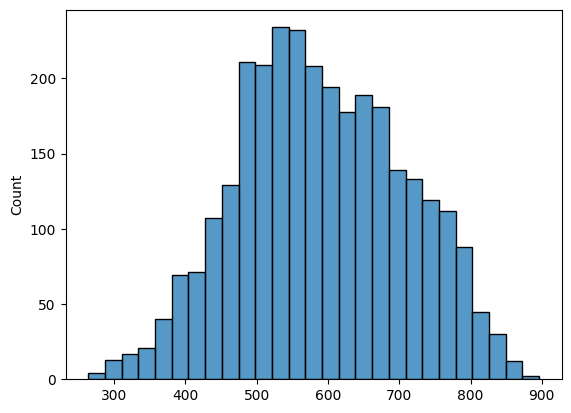

In [17]:
# Normalize by median count depth with log plus one (log1p) transformation
# Normalize to total counts
sc.preprocessing.normalize_total(adata)
# Transform using log1p
sc.preprocessing.log1p(adata)

# Check
sns.histplot(adata.X.sum(1))

# Feature selection

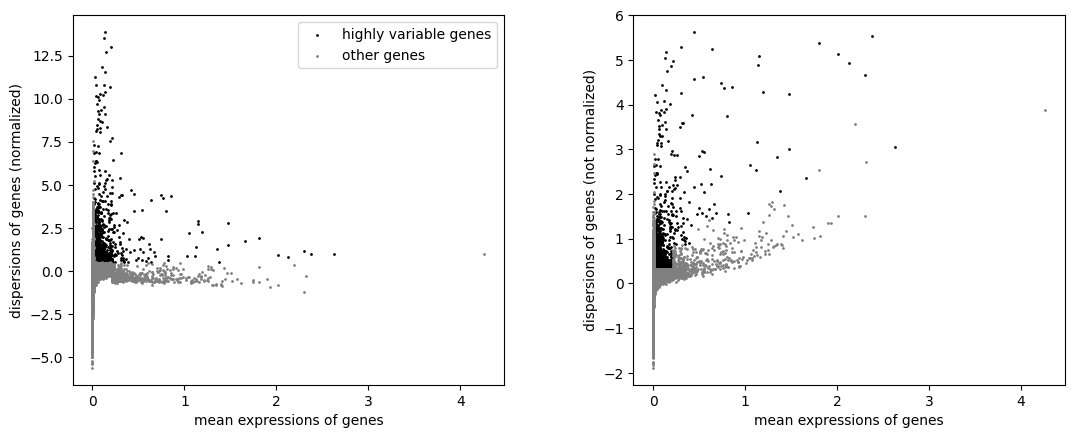

In [18]:
# Run Seurat
sc.preprocessing.highly_variable_genes(adata)

# Plot results
sc.plotting.highly_variable_genes(adata)

# Dimensionality reduction

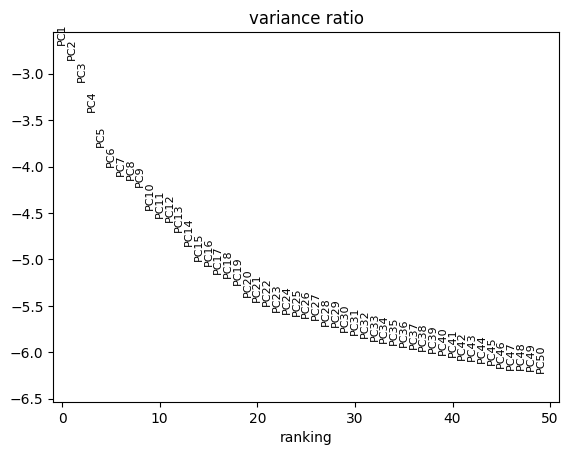

In [19]:
# Perform PCA on normalized data
sc.tools.pca(adata, svd_solver="arpack", mask_var="highly_variable")

# Plot variance ratio
sc.plotting.pca_variance_ratio(
    adata,
    n_pcs=50,
    log=True # y-axis
)

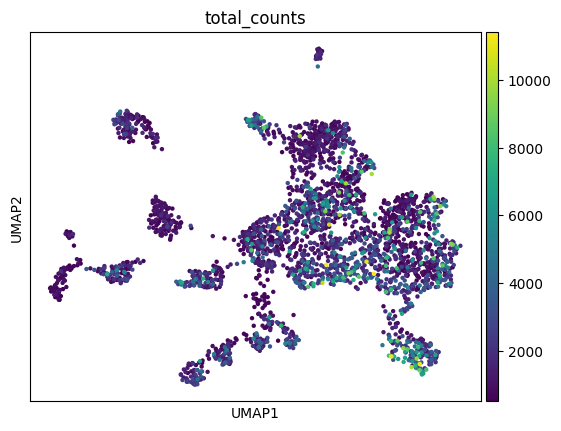

In [20]:
# Construct neighbourhood graph
sc.preprocessing.neighbors(adata, 
                           n_pcs=30
                           )

# Construct UMAP
sc.tools.umap(adata)

# Plot UMAP
sc.plotting.umap(
    adata,
    color="total_counts"
)

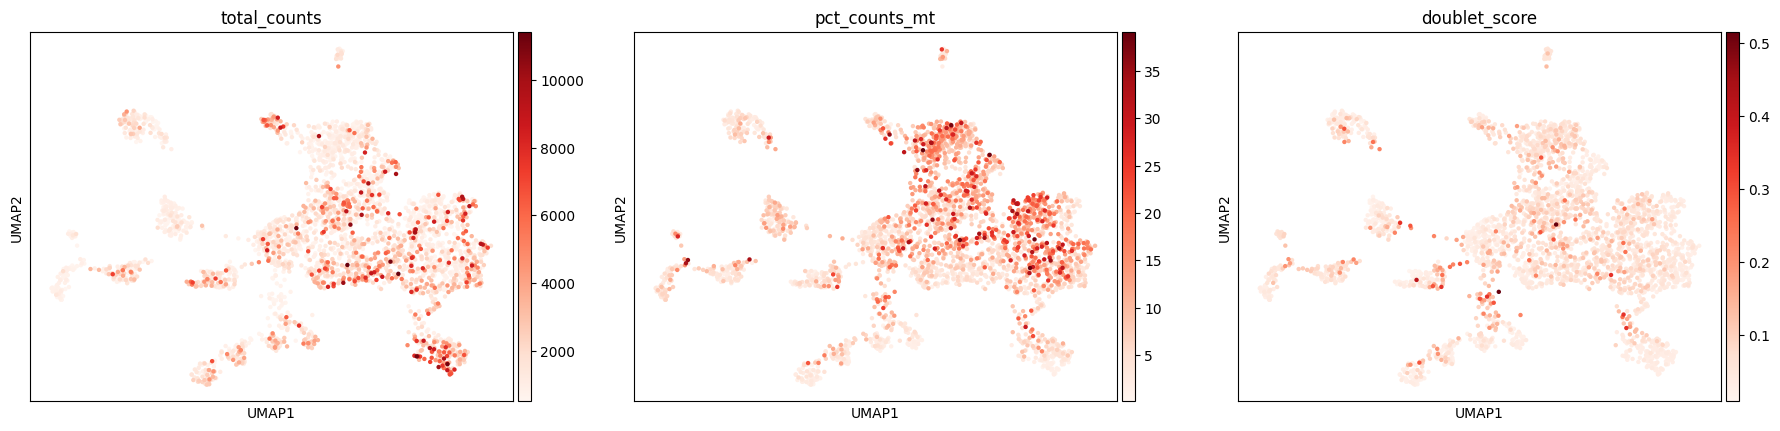

In [21]:
# Plot QC metrices
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "doublet_score"],
    cmap="Reds"
)

# Clustering

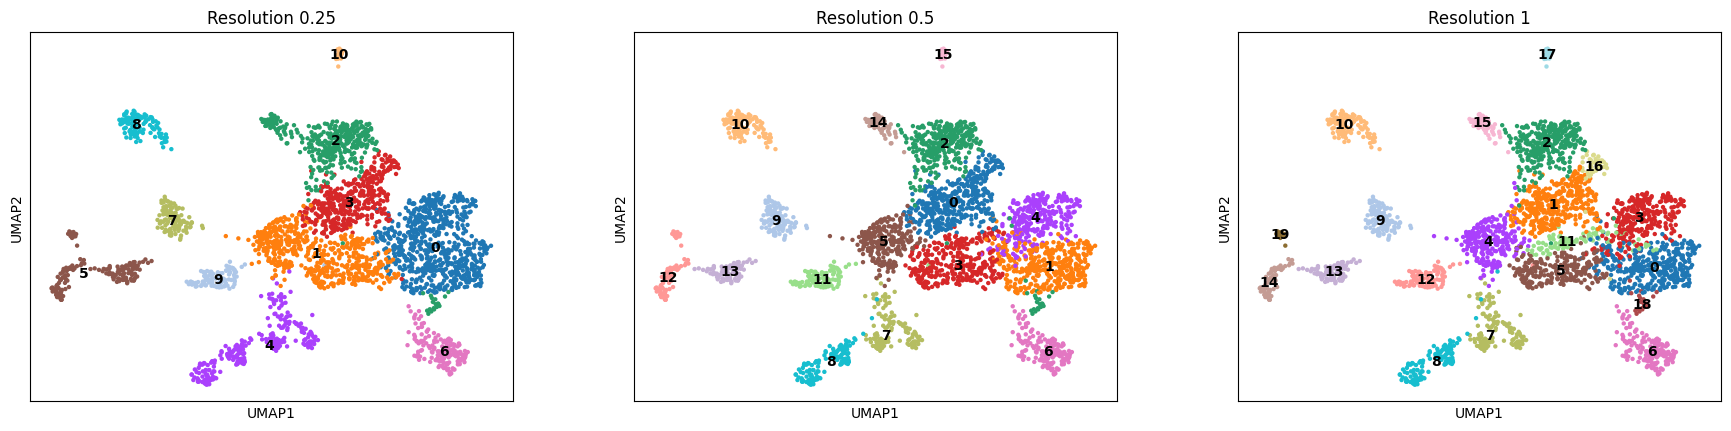

In [22]:
# Cluster at different resolutions
sc.tl.leiden(adata, key_added="leiden_res_025", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res_05", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res_1", resolution=1.0)

# Plot
sc.pl.umap(
    adata, 
    color=["leiden_res_025", "leiden_res_05", "leiden_res_1"], 
    legend_loc="on data",
    title=["Resolution 0.25", "Resolution 0.5", "Resolution 1"]
    )

# Cell annotation

In [23]:
# Prepare count data for celltypist
adata_celltypist = adata.copy()
adata_celltypist.X = adata.layers["raw_counts"]
# Normalize raw counts to 1e4 per cell
sc.preprocessing.normalize_total(adata_celltypist, target_sum=1e4)
# Log + pseudocount transform
sc.preprocessing.log1p(adata_celltypist)

# Load model of human lung atlas
models.download_models(force_update=True, model="Human_Lung_Atlas.pkl")
atlas_model = models.Model.load("Human_Lung_Atlas.pkl")

# Perform classification
predictions_atlas = celltypist.annotate(adata_celltypist, model=atlas_model, majority_voting=True)
# Create new adata object
predictions_atlas = predictions_atlas.to_adata()
# Save predicted labels and confidence scores in original anndata object
adata.obs["celltypist_atlas"] = predictions_atlas.obs.loc[adata.obs.index, "majority_voting"]
adata.obs["celltypist_atlas_conf_score"] = predictions_atlas.obs.loc[adata.obs.index, "conf_score"]

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 48
📂 Storing models in /home/manuel/.celltypist/data/models
💾 Total models to download: 1
💾 Downloading model [1/1]: Human_Lung_Atlas.pkl
🔬 Input data has 2987 cells and 18478 genes
🔗 Matching reference genes in the model
🧬 4309 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


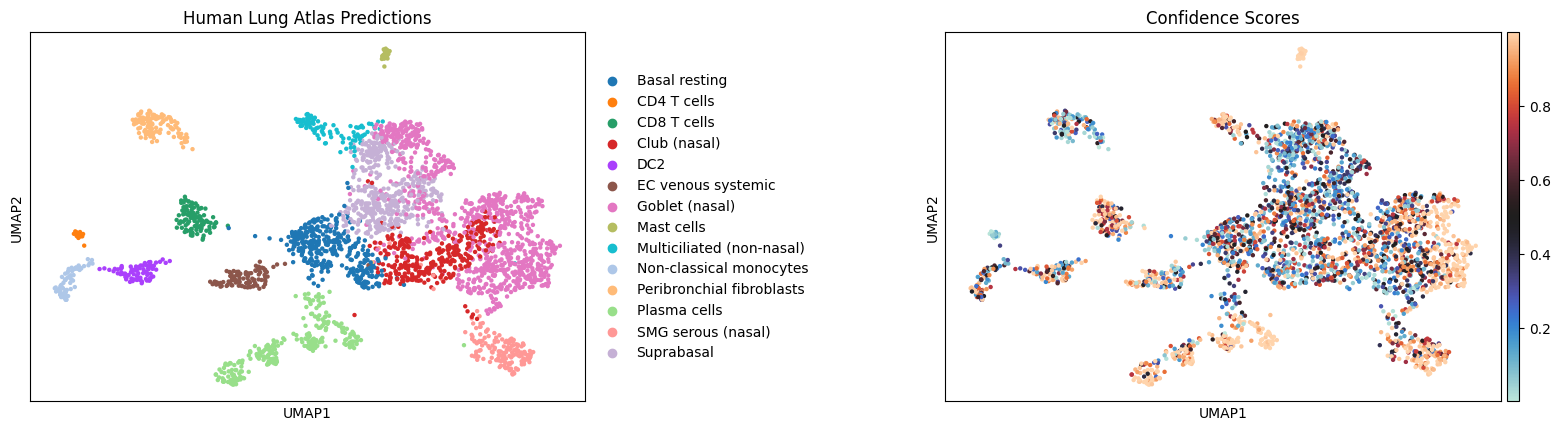

In [24]:
# Check predictions
sc.pl.umap(
    adata,
    color=["celltypist_atlas", "celltypist_atlas_conf_score"],
    sort_order=False,
    wspace=0.5,
    cmap="icefire",
    title=["Human Lung Atlas Predictions", "Confidence Scores"],
    save="predictions.png"
)

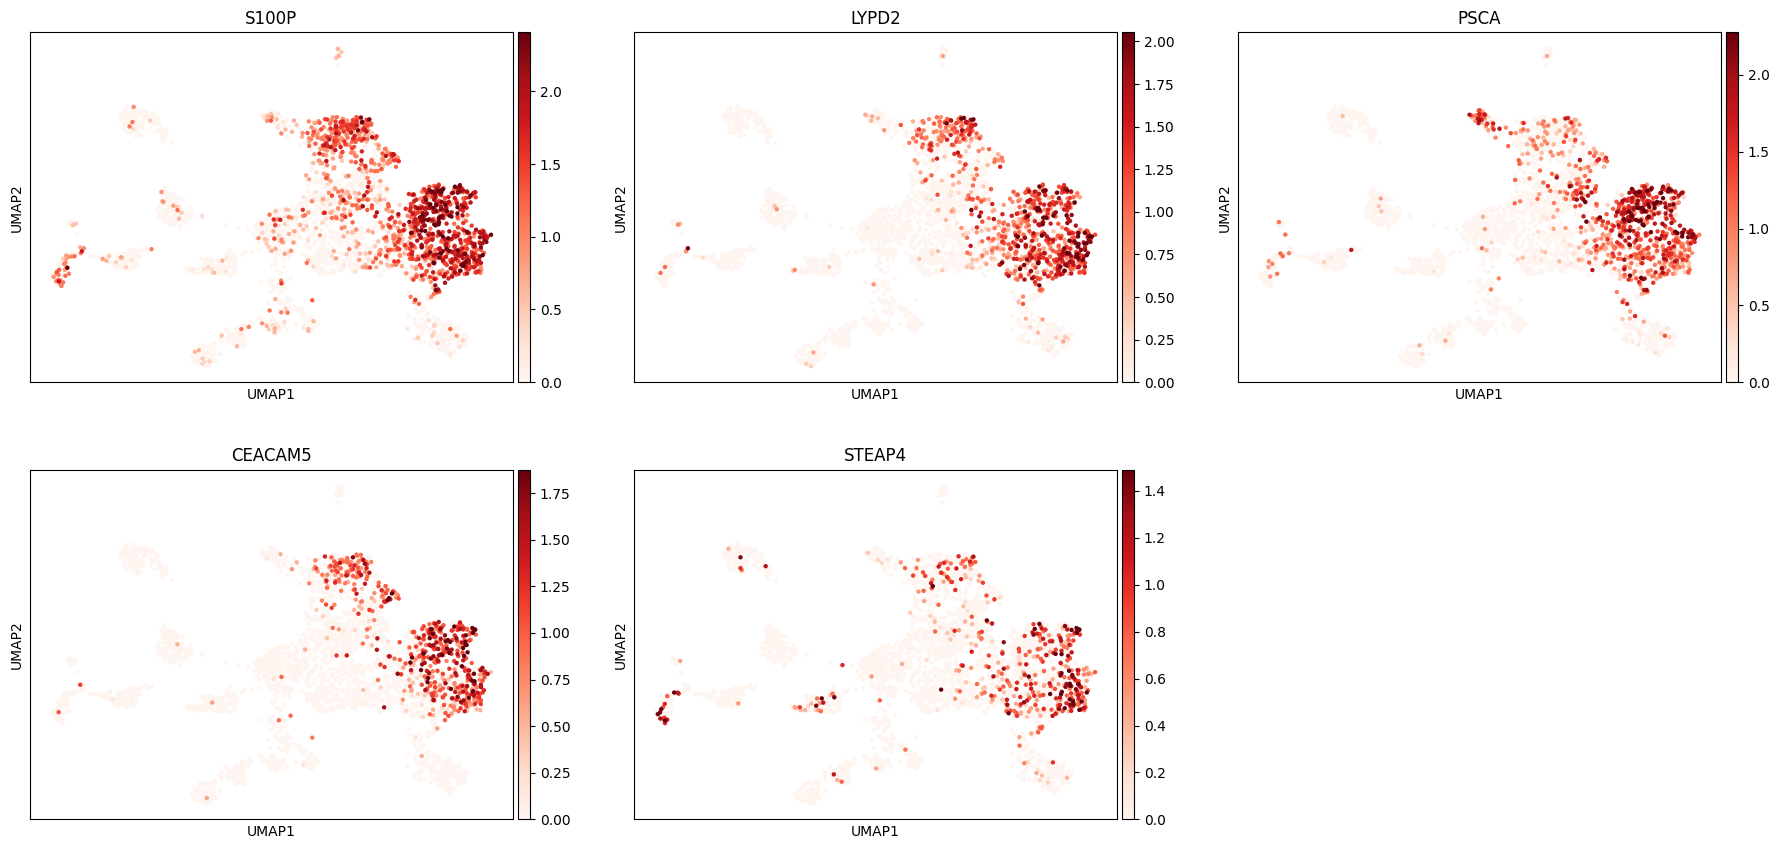

In [25]:
# Plot marker genes for goblet cells
sc.pl.umap(
    adata,
    color=["S100P", "LYPD2", "PSCA", "CEACAM5", "STEAP4"],
    ncols=3,
    cmap="Reds",
    vmin=0,
    vmax="p99",
    save="markers.png"
)

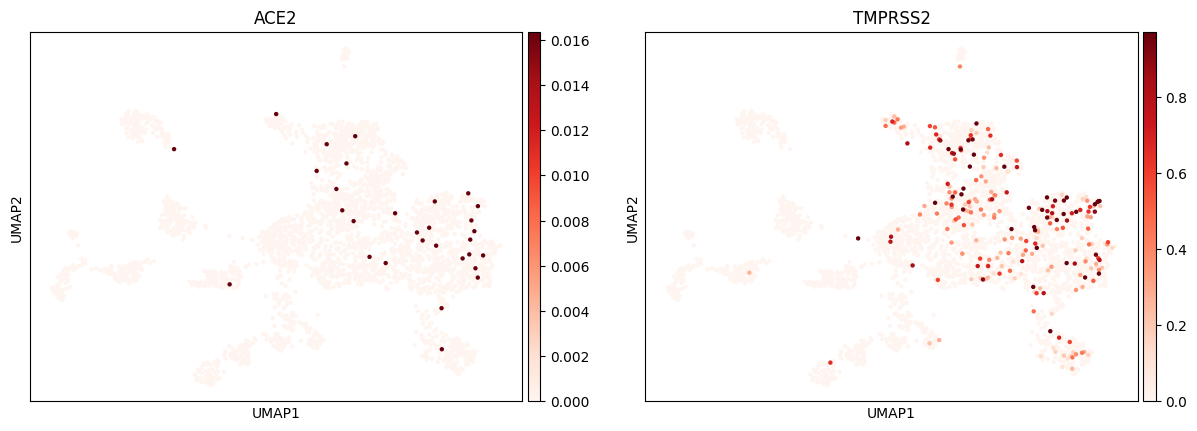

In [26]:
# Plot occurences of ACE2 and TMPRSS2
sc.pl.umap(
    adata,
    color=["ACE2", "TMPRSS2"],
    cmap="Reds",
    vmin=0,
    vmax="p99",
    save="ace2_tmprss2.png"
)